In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import sklearn.cluster as cluster
import plotly.express as px
import seaborn as sns
import warnings

In [3]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [4]:
df_in = pd.read_csv("./data/telco_churn_data.csv")
df_in.head()

,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Regular Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,City,Zip Code,Latitude,Longitude,Population,Churn Value,CLTV,Churn Category,Churn Reason,Total Customer Svc Requests,Product/Service Issues Reported,Customer Satisfaction
0,8779-QRDMV,No,0,1,NaN,No,0.00,No,Yes,Fiber Optic,9,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,41.236,39.65,0.00,0.0,0.00,Male,78,No,Yes,No,No,0,Los Angeles,90022,34.023810,-118.156582,68701,1,5433,Competitor,Competitor offered more data,5,0,NaN
1,7495-OOKFY,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Cable,19,No,Yes,No,No,No,No,No,No,Month-to-Month,Yes,Credit Card,83.876,633.30,0.00,120.0,390.80,Female,74,No,Yes,Yes,Yes,1,Los Angeles,90063,34.044271,-118.185237,55668,1,5302,Competitor,Competitor made better offer,5,0,NaN
2,1658-BYGOY,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,57,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,99.268,1752.55,45.61,0.0,203.94,Male,71,No,Yes,No,Yes,3,Los Angeles,90065,34.108833,-118.229715,47534,1,3179,Competitor,Competitor made better offer,1,0,NaN
3,4598-XLKNJ,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,13,No,Yes,Yes,No,Yes,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,102.440,2514.50,13.43,327.0,494.00,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,-118.332639,27778,1,5337,Dissatisfaction,Limited range of services,1,1,2.0
4,4846-WHAFZ,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Cable,15,No,No,No,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,79.560,2868.15,0.00,430.0,234.21,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,-118.020188,26265,1,2793,Price,Extra data charges,1,0,2.0


In [5]:
# Redundant
drop_columns = [
    "Under 30",
    "Senior Citizen",
    "Dependents",
    "City",
    "Latitude",
    "Longitude",
]

# Many/mostly null
drop_columns += df_in.loc[
    :, df_in.isnull().sum() / df_in.isnull().count() * 100.0 > 10.0
].columns.to_list()

# Non-numeric
drop_columns += df_in.columns[df_in.dtypes == "object"].to_list()

# Perform the drop
df = df_in.drop(columns=drop_columns)

assert np.all(df.isnull().sum() == 0), "Some Nulls Remain"

df.head()

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Regular Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Age,Number of Dependents,Zip Code,Population,Churn Value,CLTV,Total Customer Svc Requests,Product/Service Issues Reported
0,0,1,0.00,9,41.236,39.65,0.00,0.0,0.00,78,0,90022,68701,1,5433,5,0
1,1,8,48.85,19,83.876,633.30,0.00,120.0,390.80,74,1,90063,55668,1,5302,5,0
2,0,18,11.33,57,99.268,1752.55,45.61,0.0,203.94,71,3,90065,47534,1,3179,1,0
3,1,25,19.76,13,102.440,2514.50,13.43,327.0,494.00,78,1,90303,27778,1,5337,1,1
4,1,37,6.33,15,79.560,2868.15,0.00,430.0,234.21,80,1,90602,26265,1,2793,1,0


In [6]:
def df_scatter_3d(
    data_frame: pd.DataFrame = None,
    color: str = None,
):
    px.scatter_3d(
        data_frame=data_frame,
        x=data_frame.columns[0],
        y=data_frame.columns[1],
        z=data_frame.columns[2],
        color=color,
    ).update_layout(autosize=False, width=600, height=600).show()

In [7]:
keep_columns = ["Latitude", "Longitude", "Zip Code"]
df = df_in[keep_columns]
display(df.head())
# df_scatter_3d(df)

,Latitude,Longitude,Zip Code
0,34.023810,-118.156582,90022
1,34.044271,-118.185237,90063
2,34.108833,-118.229715,90065
3,33.936291,-118.332639,90303
4,33.972119,-118.020188,90602


In [8]:
df_scaled = (df - df.mean()) / df.std()
# df_scatter_3d(df_scaled)

In [9]:
kmeans = cluster.KMeans(n_clusters=6, random_state=123).fit(df_scaled)
(unique_labels, counts) = np.unique(kmeans.labels_, return_counts=True)
display([unique_labels, counts, kmeans.inertia_])

# df_scatter_3d(df_scaled.join(pd.DataFrame({"kmeans": kmeans.labels_})), color="kmeans")

[array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([1621, 1502,  682, 1190, 1585,  463]),
 1757.4026908819892]

In [10]:
pca = PCA(n_components=3, random_state=123).fit(df_scaled)
X = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(X, columns=["Component" + str(k + 1) for k in range(X.shape[1])])
df_pca.head()
# df_scatter_3d(df_pca)

,Component1,Component2,Component3
0,-2.008905,-0.776283,0.411140
1,-1.983824,-0.770418,0.402789
2,-1.955987,-0.783839,0.415287
3,-1.896974,-0.731961,0.283293
4,-1.878945,-0.515534,0.280210


In [23]:
min_samples = 200

distances = (
    NearestNeighbors(n_neighbors=min_samples, algorithm="auto")
    .fit(df_scaled)
    .kneighbors(df_scaled)[0]
)

distances = np.sort(np.mean(distances, axis=1))

In [24]:
# Verification of K-distance
if 1:
    distances_verify = None
else:
    X = np.array(df_scaled)
    dist = np.zeros((len(X),))

    # For each point (row), compute distance from it to every other point (all rows)
    # Sort these distances and keep the N first (N smallest distances)
    # Take the average of these

    for k in range(len(X)):
        dist[k] = np.mean(np.sort(np.linalg.norm(X - X[k, :], axis=1))[:min_samples])

    distances_verify = np.sort(dist)

Text(0.5, 1.0, 'K-Distance Graph for 200 Nearest Neighbors')

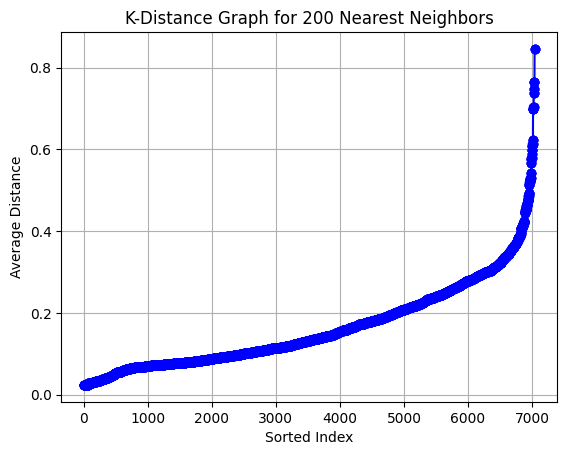

In [26]:
fig, ax = plt.subplots()
ax.plot(
    distances,
    linestyle="solid",
    marker="o",
    color="blue",
)

if distances_verify:
    ax.plot(distances_verify, marker=".", color="red")

ax.set_xlabel("Sorted Index")
ax.set_ylabel("Average Distance")
ax.grid()
plt.title("K-Distance Graph for %d Nearest Neighbors" % min_samples)

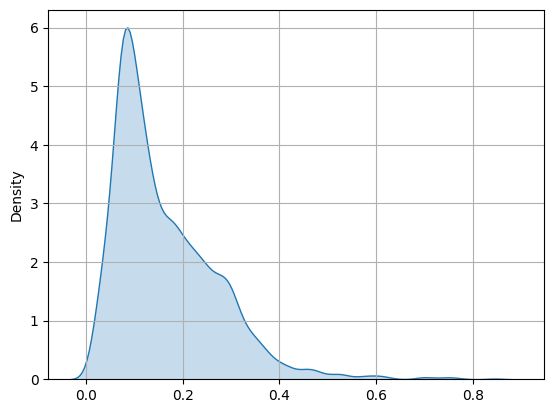

In [27]:
sns.kdeplot(distances, shade=True)
plt.grid()

In [31]:
dbscan = cluster.DBSCAN(eps=0.35, min_samples=min_samples).fit(df_scaled)
(unique_labels, counts) = np.unique(dbscan.labels_, return_counts=True)
display([unique_labels, counts])

[array([-1,  0,  1,  2]), array([ 880, 2902,  566, 2695])]

In [22]:
optics = cluster.OPTICS(min_samples=min_samples).fit(df_scaled)
(unique_labels, counts) = np.unique(optics.labels_, return_counts=True)
display([unique_labels, counts])

[array([-1,  0,  1]), array([5592,  794,  657])]

In [ ]:
df_scatter_3d(df_scaled.join(pd.DataFrame({"dbscan": dbscan.labels_})), color="dbscan")

In [ ]:
epsilons = np.arange(0.1, 10, 0.2)
n_clusters_list = []
n_noise_list = []

for eps in epsilons:
    db = DBSCAN(eps=eps).fit(X)
    predictions = db.labels_
    n_clusters_list.append(len(np.unique(predictions)))
    n_noise_list.append(np.sum(predictions == -1))

In [ ]:
fig, ax1 = plt.subplots()

ax1_color = "black"
ax1.plot(
    epsilons,
    n_clusters_list,
    linestyle="solid",
    marker="o",
    color=ax1_color,
)

ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Number of Clusters")
ax1.grid()

ax2_color = "blue"
ax2 = ax1.twinx()
ax2.plot(
    epsilons,
    n_noise_list,
    linestyle="solid",
    marker="o",
    color=ax2_color,
)

ax2.set_ylabel("Number of Noise Values", color=ax2_color)
ax2.tick_params(axis="y", labelcolor=ax2_color)